In [2]:
import re
from jiwer import wer, cer, process_words
import sacrebleu
import pandas as pd
import pymupdf
import pypdfium2 as pdfium
from pdfminer.high_level import extract_text
from PyPDF2 import PdfReader
import unicodedata
from rouge_score import rouge_scorer
from scipy.stats import kendalltau

def extract_text_from_pymupdf(pdf_path: str) -> str:
    """Extract plain text from the first page of the PDF."""
    doc = pymupdf.open(pdf_path)
    for page in doc.pages(0, 1, 1):
        text_pymupdf = page.get_text()
    text_pymupdf = text_pymupdf.replace("\n", " ")
    return text_pymupdf

def extract_text_from_pypdfium2(pdf_path: str) -> str:
    """Extract plain text from the first page of the PDF."""
    pdf = pdfium.PdfDocument(pdf_path)
    page = pdf[0]
    textpage = page.get_textpage()

    # Extract text from the whole page
    text_pypdfium = textpage.get_text_bounded()

    text_pypdfium = text_pypdfium.replace("\n", " ")
    return text_pypdfium

def extract_text_from_pdfminer(pdf_path: str) -> str:
    """Extract plain text from the first page of the PDF."""
    text_pdfminer = extract_text(pdf_path, page_numbers=[0])#, laparams=lap)
    text_pdfminer = text_pdfminer.replace("\n", " ")
    return text_pdfminer

def extract_text_from_pypdf2(pdf_path: str) -> str:
    """Extract plain text from the first page of the PDF."""
    reader = PdfReader(pdf_path)
    page = reader.pages[0]
    text_pypdf=page.extract_text()
    text_pypdf = text_pypdf.replace("\n", " ")
    return text_pypdf

def calculate_kendall_tau(ref, hyp):
    # 3) reading-order (Kendall τ over shared tokens)
    ref_tokens = ref.split()
    hyp_tokens = hyp.split()
    positions, ref_map = [], {}
    for i, tok in enumerate(ref_tokens):
        ref_map.setdefault(tok, []).append(i)
    for tok in hyp_tokens:
        if tok in ref_map and ref_map[tok]:
            positions.append(ref_map[tok].pop(0))
    tau, _ = kendalltau(positions, sorted(positions)) if len(positions) > 1 else (1, None)
    order_error = (1 - tau)                              # 0 = perfect order, 2 = reversed
    return order_error

def normalize_text(text: str) -> str:
    """Normalize text: lowercase, remove punctuation, and trim whitespace."""
    # Lowercase the text
    text = text.lower()
    text = unicodedata.normalize("NFKC", text)
    # Remove punctuation (retain letters, numbers, and whitespace)
    #text = re.sub(r'[^\w\s]', '', text)
    # Replace one or more whitespace characters (newline, tabs) with a single space
    text = re.sub(r'\s+', ' ', text)
    # Strip leading and trailing whitespace
    text = text.strip()
    return text

def compute_alignment_metrics(ref_text: str, hyp_text: str) -> tuple:
    """
    Align reference and hypothesis texts at word level, returning:
    (hits, substitutions, deletions, insertions).
    """
    # Use jiwer to get alignment info
    alignment = process_words([ref_text], [hyp_text])
    hits = alignment.hits         # correctly matched words
    subs = alignment.substitutions  # substitutions (words in ref replaced by others in hyp)
    dels = alignment.deletions     # deletions (words missing in hyp)
    ins = alignment.insertions     # insertions (extra words in hyp)
    return hits, subs, dels, ins

def compute_metrics(ref_text: str, hyp_text: str, arxiv_id) -> dict:
    """Compute WER, CER, Precision, Recall, F1, and BLEU given reference and hypothesis text."""
    metrics = {}
    # Word Error Rate and Character Error Rate
    metrics["WER"] = round(wer(ref_text, hyp_text), 4)            # e.g., 0.05 for 5% error
    metrics["CER"] = round(cer(ref_text, hyp_text), 4)            # e.g., 0.02 for 2% char error

    # Alignment-based metrics for Precision, Recall, F1
    hits, subs, dels, ins = compute_alignment_metrics(ref_text, hyp_text)
    # Avoid division by zero
    total_pred_words = hits + subs + ins  # total words in hypothesis
    total_ref_words = hits + subs + dels  # total words in reference
    if total_pred_words == 0:
        precision = 0.0
    else:
        precision = hits / total_pred_words
    if total_ref_words == 0:
        recall = 0.0
    else:
        recall = hits / total_ref_words
    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    metrics["precision"] = round(precision, 4)
    metrics["recall"] = round(recall, 4)
    metrics["f1"] = round(f1, 4)

    metrics["order_error"] = round(calculate_kendall_tau(ref_text, hyp_text), 4)

    # BLEU score using sacrebleu
    bleu = sacrebleu.corpus_bleu(hypotheses=[hyp_text], references=[[ref_text]])
    metrics["BLEU"] = round(bleu.score / 100.0, 4)  # sacrebleu.score is out of 100, convert to 0-1
    metrics["rouge_score"] = round(rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)\
                          .score(target=ref_text, prediction=hyp_text)['rougeL'].fmeasure, 4)
    metrics["arxiv_id"] = arxiv_id
    return metrics

def main():
    scores =  {}
    tools = ["pymupdf", "pypdfium2", "pdfminer", "pypdf2"]
    for t in tools: scores[t] = []

    df = pd.read_csv("../../data/pdf_extraction_data/metadata.csv")

    for _, row in df.iterrows():

        pdf_file = row.loc["pdf_path"]
        annotation = row.loc["text"]
        arxiv_id = row.loc["arxiv_id"]


        # Extract text from PDF first page
        text_pymupdf = normalize_text(extract_text_from_pymupdf(pdf_file))
        text_pypdfium = normalize_text(extract_text_from_pypdfium2(pdf_file))
        text_pdfminer = normalize_text(extract_text_from_pdfminer(pdf_file))
        text_pypdf = normalize_text(extract_text_from_pypdf2(pdf_file))
        # Read the ground truth text from file
        with open(annotation, 'r', encoding='utf-8') as f:
            ground_truth_text = f.read()
            
        # Normalize both texts
        norm_truth = normalize_text(ground_truth_text)

        # Compute all metrics
        #results = compute_metrics(norm_truth, text_pymupdf)
        #print(results)
        scores["pymupdf"].append(compute_metrics(norm_truth, text_pymupdf, arxiv_id))
        scores["pypdfium2"].append(compute_metrics(norm_truth, text_pypdfium, arxiv_id))
        scores["pdfminer"].append(compute_metrics(norm_truth, text_pdfminer, arxiv_id))
        scores["pypdf2"].append(compute_metrics(norm_truth, text_pypdf, arxiv_id))

    return scores

In [3]:
s = main()

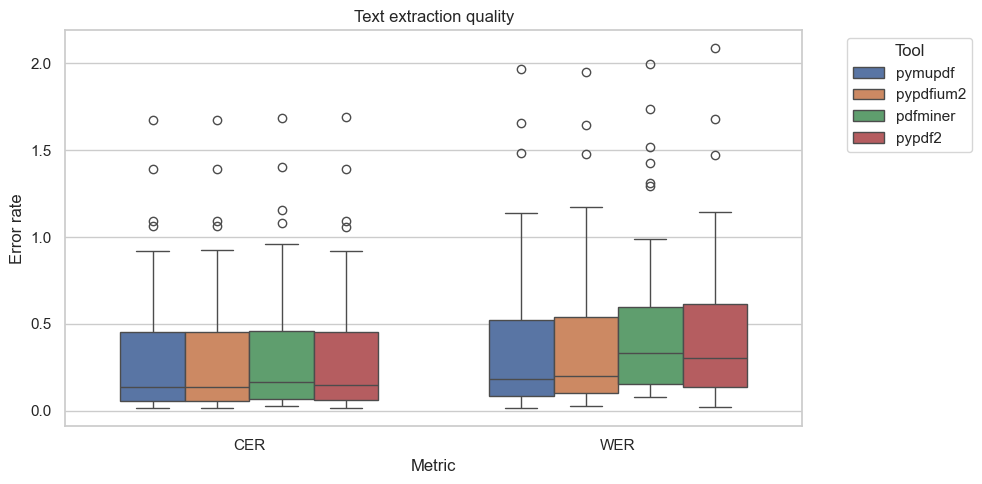

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   # convenient for grouped box-plots


# ---- reshape to “long” format ----
records = [
    {"Tool": tool, **metric_dict}
    for tool, metric_list in s.items()
    for metric_dict in metric_list
]
df = pd.DataFrame(records)

# Melt so each metric becomes a row instead of a column
long_df = df.melt(
    id_vars="Tool",
    value_vars=["CER", "WER"],
    var_name="Metric",
    value_name="Score",
)

# ---- draw the box-plot ----
sns.set(style="whitegrid")                    # nicer defaults
plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=long_df,
    x="Metric",
    y="Score",
    hue="Tool",
    width=0.7,
)
ax.set_title("Text extraction quality")
ax.set_ylabel("Error rate")
plt.legend(title="Tool", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


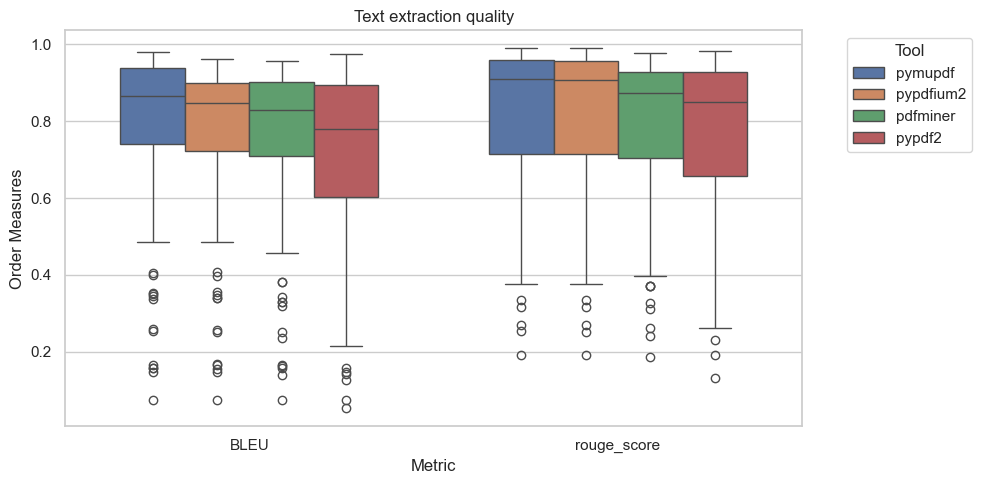

In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   # convenient for grouped box-plots


# ---- reshape to “long” format ----
records = [
    {"Tool": tool, **metric_dict}
    for tool, metric_list in s.items()
    for metric_dict in metric_list
]
df = pd.DataFrame(records)

# Melt so each metric becomes a row instead of a column
long_df = df.melt(
    id_vars="Tool",
    value_vars=["BLEU", "rouge_score"],
    var_name="Metric",
    value_name="Score",
)

# ---- draw the box-plot ----
sns.set(style="whitegrid")                    # nicer defaults
plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=long_df,
    x="Metric",
    y="Score",
    hue="Tool",
    width=0.7,
)
ax.set_title("Text extraction quality")
ax.set_ylabel("Order Measures")
plt.legend(title="Tool", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [6]:
from collections import defaultdict
from statistics import mean
from numbers import Number   # to detect numeric values

def summarize_metrics(data, verbose=True):
    """
    Compute average and max for every numeric metric inside each extractor.

    Parameters
    ----------
    data : dict[str, list[dict]]
        Outer keys are extractor names; values are lists of metric dictionaries.
    verbose : bool, default True
        If True, print a neat table; the function always returns the summary dict.

    Returns
    -------
    dict[str, dict[str, float]]
        Nested dictionary: {extractor: {metric: value, ...}, ...}
        For each metric both 'avg_<metric>' and 'max_<metric>' are provided.
    """
    summary = {}

    for extractor, records in data.items():
        # Collect metric → list of values
        metric_values = defaultdict(list)

        for rec in records:
            for metric, value in rec.items():
                if isinstance(value, Number):
                    metric_values[metric].append(value)

        # Build the statistics
        stats = {}
        for metric, values in metric_values.items():
            stats[f'avg_{metric}'] = mean(values)
            #stats[f'max_{metric}'] = max(values)

        summary[extractor] = stats

    if verbose:
        # Pretty-print: each extractor on its own line
        for extractor, stats in summary.items():
            parts = [f"{k}={v:.4f}" for k, v in sorted(stats.items())]
            print(f"{extractor:<10}  " + "  ".join(parts))

    return summary

x = summarize_metrics(s)

pymupdf     avg_BLEU=0.7817  avg_CER=0.2805  avg_WER=0.3544  avg_arxiv_id=1575.5140  avg_f1=0.7733  avg_order_error=0.1252  avg_precision=0.7649  avg_recall=0.7879  avg_rouge_score=0.8086
pypdfium2   avg_BLEU=0.7606  avg_CER=0.2832  avg_WER=0.3707  avg_arxiv_id=1575.5140  avg_f1=0.7558  avg_order_error=0.1267  avg_precision=0.7501  avg_recall=0.7676  avg_rouge_score=0.8070
pdfminer    avg_BLEU=0.7499  avg_CER=0.2997  avg_WER=0.4437  avg_arxiv_id=1575.5140  avg_f1=0.7368  avg_order_error=0.1585  avg_precision=0.7018  avg_recall=0.7829  avg_rouge_score=0.7825
pypdf2      avg_BLEU=0.7089  avg_CER=0.2899  avg_WER=0.4184  avg_arxiv_id=1575.5140  avg_f1=0.7064  avg_order_error=0.1468  avg_precision=0.7086  avg_recall=0.7120  avg_rouge_score=0.7643


In [7]:
from numbers import Number
from math import inf

# set of metrics for which we want the minimum
min_metrics = {'avg_WER', 'avg_CER', 'avg_order_error'}

# discover all avg_ metrics
all_metrics = {m for stats in x.values() for m in stats if m.startswith("avg_")}

# find the best tool for each metric, using min or max as specified
best_locations = {}
for metric in all_metrics:
    if metric in min_metrics:
        # for these, pick the tool with the smallest value
        best_tool, best_val = min(
            x.items(),
            key=lambda kv: kv[1].get(metric, inf)
        )
    else:
        # for all others, pick the tool with the largest value
        best_tool, best_val = max(
            x.items(),
            key=lambda kv: kv[1].get(metric, -inf)
        )

    # strip off "avg_" prefix if you like
    clean_name = metric[len("avg_"):]
    best_locations[clean_name] = best_tool

best_locations

{'CER': 'pymupdf',
 'recall': 'pymupdf',
 'f1': 'pymupdf',
 'BLEU': 'pymupdf',
 'rouge_score': 'pymupdf',
 'arxiv_id': 'pymupdf',
 'WER': 'pymupdf',
 'precision': 'pymupdf',
 'order_error': 'pymupdf'}